In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydicom

In [3]:
!pip install medpy

In [4]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import TensorBoard
from IPython.display import clear_output
import pydicom
import skimage.io
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage import metrics
from skimage.metrics import adapted_rand_error
import cv2
import medpy
from medpy.metric.binary import dc, hd, precision, recall
from datetime import datetime
import statistics
from statistics import *

# Set neural network hyperparameters
N_EPOCHS = 100
LEARN_R = 1e-4
BATCH_SZ = 1
SZ = 128

path = ('/content/drive/My Drive/Assignment4/lv_deeplearning')

train_dir = os.path.join(path,'training')
test_dir = os.path.join(path,'test')

In [5]:
# Display code for image and label
def display_im_label(img, lbl, titlef=""): # display the MR images along with ground truth labels
    
    mask = np.ma.masked_where(lbl == 0, lbl)
    clear_output(wait=True) # clear figure
    plt.figure(figsize=(5,5))                 
    # show MR image
    plt.imshow(img, cmap='gray') 
    plt.imshow(mask, alpha=0.3)   
    plt.axis('off')

    plt.pause(0.1)  

In [6]:
# Normalize image using 5th and 95th percentile values
def im_normalize(img):
    im_min, im_max = np.percentile(img,[5,95])
    return np.clip(np.array((img-im_min)/(im_max-im_min), dtype=np.float32), 0.0, 1.0)

In [7]:
# Perform image cropping from center
def crop_center(img, lbl, crx, cry):
    y, x = img.shape
    sx = x//2-(crx//2)
    sy = y//2-(cry//2)    
    return img[sy:sy+cry,sx:sx+crx], lbl[sy:sy+cry,sx:sx+crx]

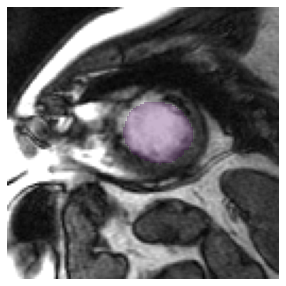

In [8]:
# Load images and labels
fimg_names = glob.glob(os.path.join(train_dir,'*.dcm'))

train_img1, train_img, train_lbl , valid_img , valid_img1, train_lbl1 = [], [] ,[] ,[] ,[], []

for fimg in fimg_names:
    ds = pydicom.read_file(fimg)
    lbl = skimage.io.imread("{}.png".format(fimg[:-4]))
    img = im_normalize(ds.pixel_array)
    img, lbl= crop_center(img,lbl,SZ,SZ)
    
    train_img1.append(img)
    train_lbl.append(lbl)

    
    display_im_label(img,lbl)

train_img = train_img1[0:8]
train_lbl = train_lbl[0:8]

# Set validation images
valid_img = train_img1[8:10]
valid_lbl = train_lbl[8:10]

In [9]:
# Set train image and label dimensions to 4 to be compatible with keras
train_img = np.array(train_img)[...,np.newaxis]
train_lbl = (np.array(train_lbl)[...,np.newaxis]>0).astype(np.float32)
valid_img = np.array(valid_img)[...,np.newaxis]
valid_lbl = np.array(valid_img)[...,np.newaxis]

In [10]:
# Define loss function and evaluation metric

eps = 1e-5

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + eps) / (K.sum(y_true_f) + K.sum(y_pred_f) + eps)

def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [11]:
# UNet neural network model definition
def get_unet():
    inputs = Input((SZ, SZ, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=LEARN_R), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [12]:
# Create neural network model and print its details
model = get_unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [13]:
%%timeit -n 1 -r 1

# Perform neural network training
print("train img", train_img.shape, type(train_img[0,0,0,0]), np.min(train_img), np.max(train_img))
print("train lbl", train_lbl.shape, type(train_lbl[0,0,0,0]), np.min(train_lbl), np.max(train_lbl))
print("validation img", valid_img.shape, type(valid_img[0,0,0,0]), np.min(valid_img), np.max(valid_img))   
print("Training data loaded successfully.\n")

# With Save Best only
print("Loading network...")
model_checkpoint = ModelCheckpoint(os.path.join('trained_models', 'trained_unet.h5'), monitor='val_loss') #save_best_only=True)
tbCallBack = TensorBoard(log_dir=os.path.join('trained_models', 'Graph', "train_ep{:04d}_lr{}_bsz_{:02d}".format(N_EPOCHS, LEARN_R, BATCH_SZ)), write_graph=False, write_images=False)
print("Network loaded successfully.")

print("Starting network training ...")
model.fit(train_img, train_lbl[0:8], batch_size=BATCH_SZ, epochs=N_EPOCHS, verbose=2, validation_split=0, validation_data=(valid_img,valid_lbl), validation_steps = 10, validation_batch_size=1, callbacks=[model_checkpoint,tbCallBack])    
print("Network trained successfully.")   

K.clear_session()  

print("done.")

train img (8, 128, 128, 1) <class 'numpy.float32'> 0.0 1.0
train lbl (8, 128, 128, 1) <class 'numpy.float32'> 0.0 1.0
validation img (2, 128, 128, 1) <class 'numpy.float32'> 0.017301038 1.0
Training data loaded successfully.

Loading network...
Network loaded successfully.
Starting network training ...
Epoch 1/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 - 1s - loss: 0.8250 - dice_coef: 0.1750 - val_loss: 0.5768 - val_dice_coef: 0.4232
Epoch 2/100
8/8 - 3s - loss: 0.8223 - dice_coef: 0.1777
Epoch 3/100
8/8 - 1s - loss: 0.8196 - dice_coef: 0.1804
Epoch 4/100
8/8 - 0s - loss: 0.8155 - dice_coef: 0.1845
Epoch 5/100
8/8 - 1s - loss: 0.8034 - dice_coef: 0.1966
Epoch 6/100
8/8 - 0s - loss: 0.7786 - dice_coef: 0.2214
Epoch 7/100
8/8 - 3s - loss: 0.7691 - dice_coef: 0.2309
Epoch 8/100
8/8 - 3s - loss: 0.7407 - dice_coef: 0.2593
Epoch 9/100
8/8 - 1s - loss: 0.6847 - dice_coef: 0.3153
Epoch 10/100
8/8 - 0s - loss: 0.4435 - dice_coef: 0.5565
Epoch 11/100
8/8 - 1

In [14]:
# Display MR image along with label
def display_im_label(img, lbl, titlef=""): 
    
    mask = np.ma.masked_where(lbl == 0, lbl)
    clear_output(wait=True) # clear figure
    plt.figure(figsize=(5,5))                 
    # show MR image
    plt.imshow(img, cmap='gray') 
    plt.imshow(mask, alpha=0.3)   
    plt.axis('off')

    plt.pause(0.01)  


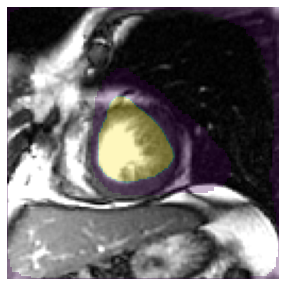

Duration: 0:00:02.095950


In [15]:
# %%timeit -n 1 -r 1
# Evaluation

start_time = datetime.now()

# Iterate over test image and predict segmentation label
fimgs = glob.glob(os.path.join(test_dir, '*.dcm'))
result_img = []

for fim in fimgs:
    ds = pydicom.read_file(fim)
    img = ds.pixel_array
    
    img = im_normalize(img)
    img, _ = crop_center(img, img, SZ, SZ)
    
    test_img = img[np.newaxis, :, :, np.newaxis]
    lbl = model.predict(test_img, verbose=2) 
    result_img.append(lbl[0,:,:,0])
    
    # Comment this line when computing approximate runtime
    display_im_label(img, lbl[0,:,:,0])

result_image = np.array(result_img,dtype=int)

gt_image = []
gt_image1 = []

gt_path = ('/content/drive/My Drive/Assignment4/lv_deeplearning/test/GT')

# Load gt
for gt in os.listdir(os.path.join(gt_path)):
  gt_figure = skimage.io.imread("{}.png".format(fimg[:-4]))
  gt_figure2 = gt_figure
  gt_figure2, _ = crop_center(gt_figure2,gt_figure2,SZ,SZ)

  gt_figure = im_normalize(ds.pixel_array)
  gt_figure, _ = crop_center(gt_figure, gt_figure, SZ, SZ)

  gt_image1.append(gt_figure2)
  gt_image.append(gt_figure)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [16]:
# Evaluation matrix for recall
start_time = datetime.now()
recall_list = []

for i in range(8):
  recall = medpy.metric.binary.recall(result_image[i], gt_image1[i])

  recall_list.append(recall)

print(recall_list)
print('mean=',mean(recall_list))
print('group std=',pstdev(recall_list))
print('sample std',stdev(recall_list))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[0.10073710073710074, 0.4348894348894349, 0.0, 0.5343980343980343, 0.6339066339066339, 0.3022113022113022, 0.02334152334152334, 0.45085995085995084]
mean= 0.3100429975429975
group std= 0.22716557130887607
sample std 0.24285021083102248
Duration: 0:00:00.007241


In [17]:
# Evaluation matrix for precision
start_time = datetime.now()
precision_list = []


for i in range(8):
  precision= medpy.metric.binary.precision(result_image[i], gt_image1[i])
  precision_list.append(precision)

print(precision_list)
print('mean=',mean(precision_list))
print('group std=',pstdev(precision_list))
print('sample std',stdev(precision_list))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[0.13509060955518945, 0.31663685152057247, 0.0, 0.5838926174496645, 0.5014577259475219, 0.5913461538461539, 0.06506849315068493, 0.4213547646383467]
mean= 0.3268559020135167
group std= 0.22013762253984243
sample std 0.23533701756658718
Duration: 0:00:00.005386


In [18]:
# Evaluation matrix for Hausdorff distance
start_time = datetime.now()
hd_list = []


for i in range(8):

  hd = medpy.metric.binary.hd(result_img[i],gt_image[i])
  hd_list.append(hd)

print(hd_list)
print('mean=',mean(hd_list))
print('group std=',pstdev(hd_list))
print('sample std',stdev(hd_list))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[27.294688127912362, 30.01666203960727, 31.76476034853718, 29.120439557122072, 29.120439557122072, 27.16615541441225, 34.438350715445125, 28.42534080710379]
mean= 29.668354570907766
group std= 2.2723857627824255
sample std 2.4292825642613716
Duration: 0:00:00.036066


In [19]:
# Evaluation matrix for dice score
start_time = datetime.now()
dice_list = []

for i in range(8):
  d = medpy.metric.binary.dc(result_img[i],gt_image[i])
  dice_list.append(d)

print(dice_list)
print('mean=',mean(dice_list))
print('group std=',pstdev(dice_list))
print('sample std',stdev(dice_list))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[0.5081742624897251, 0.5076944152701036, 0.568677230149698, 0.4892711801701813, 0.4920378490653127, 0.5002066590126292, 0.6057274354385068, 0.41126321430311297]
mean= 0.5103815307374087
group std= 0.053864910843741835
sample std 0.05758401187040183
Duration: 0:00:00.004531


In [20]:
# Evaluation matrix for Jaccard Coefficient
start_time = datetime.now()
jc_list = []

for i in range(8):
  jc = medpy.metric.binary.jc(result_img[i],gt_image[i])
  jc_list.append(jc)

print(jc_list)
print('mean=',mean(jc_list))
print('group std=',pstdev(jc_list))
print('sample std',stdev(jc_list))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[0.3406391575854047, 0.3402080783353733, 0.3973088685015291, 0.32386433206807885, 0.32629323538414445, 0.3335170555453488, 0.43443975793141393, 0.2588617686741077]
mean= 0.3443915317531751
group std= 0.04889148446343811
sample std 0.052267195426561885
Duration: 0:00:00.004938
